In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model,Sequential
from keras.layers import Dense
from keras.layers import Flatten ,Dropout
from keras.optimizers import Adam
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [ ]:
vgg = VGG16(include_top=False, weights='imagenet',input_shape=(150, 150, 3))
for layer in vgg.layers[:]:
    layer.trainable = False


In [ ]:
model = Sequential()
model.add(vgg)

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 25,697,286
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
train_dir ='/content/drive/MyDrive/data/seg_train'
valid_dir ='/content/drive/MyDrive/data/seg_test/'
pred_dir  = '/content/drive/MyDrive/data/seg_pred/'
#Add data-augmentation parameters to ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255., shear_range=0.2,
horizontal_flip=True)

#Generate batches and load data with real-time data augmentation.
train_generator=datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')

validation_generator=datagen.flow_from_directory(
      valid_dir,
      target_size=(150,150),
      batch_size=64,
      class_mode='categorical')

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    pred_dir, 
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical' )

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 6 classes.


In [ ]:
#Compile model

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
H = model.fit(train_generator, batch_size=128,
              epochs=25, 
              validation_data=validation_generator)
## save the model's trained weights
model.save_weights('vgg_transfer_trained_wts.h5')

Epoch 1/25
141/141 [==============================] - 185s 1s/step - loss: 1.2436 - accuracy: 0.5060 - val_loss: 0.6232 - val_accuracy: 0.7470
Epoch 2/25
141/141 [==============================] - 184s 1s/step - loss: 0.6499 - accuracy: 0.7537 - val_loss: 0.4691 - val_accuracy: 0.8313
Epoch 3/25
141/141 [==============================] - 184s 1s/step - loss: 0.5738 - accuracy: 0.7785 - val_loss: 0.4205 - val_accuracy: 0.8537
Epoch 4/25
141/141 [==============================] - 185s 1s/step - loss: 0.5296 - accuracy: 0.8012 - val_loss: 0.4223 - val_accuracy: 0.8520
Epoch 5/25
141/141 [==============================] - 184s 1s/step - loss: 0.5107 - accuracy: 0.8044 - val_loss: 0.4132 - val_accuracy: 0.8490
Epoch 6/25
141/141 [==============================] - 184s 1s/step - loss: 0.5165 - accuracy: 0.8033 - val_loss: 0.4230 - val_accuracy: 0.8387
Epoch 7/25
141/141 [==============================] - 184s 1s/step - loss: 0.4870 - accuracy: 0.8140 - val_loss: 0.3747 - val_accuracy: 0.8650

In [ ]:
#Evaluating the model
score = model.evaluate(test_generator)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

115/115 [==============================] - 1866s 16s/step - loss: 0.2520 - accuracy: 0.9095
Test Loss =  0.2520221173763275
Test Accuracy =  0.9094644784927368


In [ ]:
# Making prediction
y_pred = model.predict(test_generator)
y_true = np.argmax(y_pred, axis=-1)

#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1151,    0,    0,    0,    0,    0],
       [   0, 1163,    0,    0,    0,    0],
       [   0,    0, 1555,    0,    0,    0],
       [   0,    0,    0, 1071,    0,    0],
       [   0,    0,    0,    0, 1102,    0],
       [   0,    0,    0,    0,    0, 1259]])

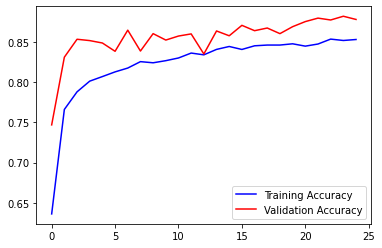

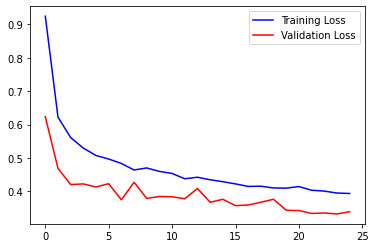

In [ ]:
# %matplotlib inline
acc=H.history['accuracy']
val_acc=H.history['val_accuracy']
loss=H.history['loss']
val_loss=H.history['val_loss']
epochs=range(len(acc)) 

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()